In [5]:
# Import necessary libraries and setup paths
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from PyISV.utils.IO_utils import find_project_root

# Set seaborn style
sns.set_theme(style="whitegrid")

# Paths to the data
root_dir = find_project_root()
print(root_dir)
data_dir = os.path.join(root_dir, "datasets")
models_dir = os.path.join(root_dir, "models/")

/home/shared_folder/PyISV


In [8]:
from PyISV.utils.features_calc_utils import calc_rdfs

# Define global constants for testing purposes
params = {
    "xyz_file": f"{root_dir}/datasets/structures/full_min_ptmd_nPt_85.xyz",
    "output_file": f"{root_dir}/datasets/RDFs/min_nPt_85.pt",
    "min_dist": 1.0,
    "max_dist": 11.0,
    "n_bins": 340,
    "bandwidth": 0.2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "species": ["Pt"],
    "mode": "single"
}

rdf_alloy, skipped = calc_rdfs(params)
print(f"Skipped {len(skipped)} frames")
print(rdf_alloy.shape)

Parameters:
xyz_file: /home/shared_folder/PyISV/datasets/structures/full_min_ptmd_nPt_85.xyz
output_file: /home/shared_folder/PyISV/datasets/RDFs/min_nPt_85.pt
min_dist: 1.0
max_dist: 11.0
n_bins: 340
bandwidth: 0.2
device: cuda
species: ['Pt']
mode: single
Total frames read: 96000
Pairs found: [('Pt', 'Pt')]


Calculating RDF: 100%|██████████| 96000/96000 [00:43<00:00, 2211.49frame/s]


Computed 96000/96000 valid frames in 43.65s
Skipped 0 frames
torch.Size([96000, 1, 340])


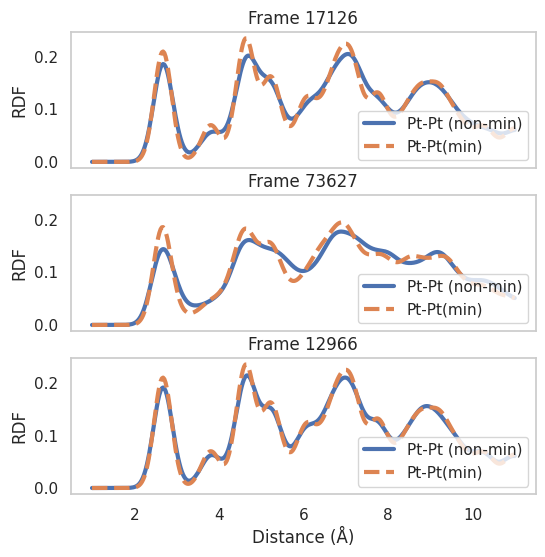

In [21]:
def plot_rdf(rdf, n_bins, min_dist, max_dist, species, label="", ls='-', frame_idx=0, ax=None) -> None:
    """Plot RDFs for a specific frame"""
    # Select a single frame to plot
    if rdf.dim() > 3:  # If we have [frames, channels, 1, bins]
        rdf_frame = rdf[frame_idx].squeeze(1)  # Remove extra dimension
    else:
        rdf_frame = rdf[frame_idx]
    
    if not ax:
        ax = plt.subplot()
    pairs = []
    for i, s1 in enumerate(species):
        for j, s2 in enumerate(species):
            if j >= i:  # Only include upper triangular pairs
                pairs.append(f"{s1}-{s2}")
    
    # Plot each channel with correct pair label
    for i, pair in enumerate(pairs):
        if i < rdf_frame.shape[0]:  # Make sure we don't exceed number of channels
            # Ensure data is 1D for plotting
            y_data = rdf_frame[i].cpu().numpy().flatten()
            sns.lineplot(
                x=np.linspace(min_dist, max_dist, n_bins), 
                y=y_data,
                label=pair+label, 
                ax=ax, lw=3, ls=ls
            )
    ax.set_xlabel("Distance (Å)")
    ax.set_ylabel("RDF")
    ax.legend(frameon=True, loc='lower right')
    ax.grid(False)

import random
rdfs = [torch.load(f"{root_dir}/datasets/RDFs/nonMin_nPt_85.pt"),
        torch.load(f"{root_dir}/datasets/RDFs/min_nPt_85.pt")]

idx_samples = random.sample(range(0, len(rdfs[0])), 3)
fig, axes = plt.subplots(
    len(idx_samples), 1, 
    sharey=True, sharex=True, 
    figsize=(6, 2 * len(idx_samples))
)

labels = [" (non-min)", "(min)"]
for i,idx in enumerate(idx_samples):
    axes[i].set_title(f"Frame {idx}")
    for j,rdf in enumerate(rdfs):
        plot_rdf(rdf, n_bins=340,
                min_dist=1.0,
                max_dist=11.0,
                species=["Pt"],
                frame_idx=idx,
                ax=axes[i],
                label=labels[j],
                ls='-' if j == 0 else '--')

